In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import pickle
import random

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import librosa as lb
import parselmouth
from parselmouth.praat import call

2025-08-12 23:13:44.705977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 23:13:44.719745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 23:13:44.839075: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 23:13:44.951853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755020625.045881    5778 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755020625.08

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

> do on by one in concatenation

> model on prosodic features

In [4]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'

train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

print(f"Train set: {train_df.shape[0]} samples, Test set: {test_df.shape[0]} samples")
print("Training Samples: ")
print(train_df.head())
print("Testing Samples: ")
print(test_df.head())

Train set: 148 samples, Test set: 48 samples
Training Samples: 
   Participant_ID   Gender  PHQ_Binary  PHQ_Score
0             302     male           0          4
1             303   female           0          0
2             304   female           0          6
3             305     male           0          7
4             307  female            0          4
Testing Samples: 
   Participant_ID  Gender  PHQ_Binary  PHQ_Score
0             300    male           0          2
1             301    male           0          3
2             306  female           0          0
3             317    male           0          8
4             320  female           0         11


In [5]:
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by=['Participant_ID'])
df = df.reset_index(drop=True)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score
0,300,male,0,2
1,301,male,0,3
2,302,male,0,4
3,303,female,0,0
4,304,female,0,6


## Features Df

In [6]:
# speech rate
speech_rate_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/speech_rate.csv')
speech_rate_df = speech_rate_df[['Participant_ID', 'Speech_Rate']]
speech_rate_df.head()

df['Speech_Rate'] = df['Participant_ID'].map(speech_rate_df.set_index('Participant_ID')['Speech_Rate'])
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Speech_Rate
0,300,male,0,2,0.423796
1,301,male,0,3,1.058485
2,302,male,0,4,0.625064
3,303,female,0,0,1.196229
4,304,female,0,6,0.868119


In [7]:
# for participant 300
participant_id = 300

############## Speech Rate
speech_rate = speech_rate_df[speech_rate_df['Participant_ID'] == participant_id]['Speech_Rate'].values[0]
print(f"Speech Rate for Participant {participant_id}: {speech_rate}")

############# Pauses
pause_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/pauses.csv')
pause_count = pause_df[pause_df['Participant_ID'] == participant_id]['Pauses'].values[0]
print(f"Pause Count for Participant {participant_id}: {pause_count}")

Speech Rate for Participant 300: 0.4237957357199261
Pause Count for Participant 300: 949


In [8]:
############ Duration
duration_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Duration/300_duration.csv')
t = 0.25
duration_df.head()
mask = (duration_df['Start'] <= t) & (duration_df['End'] >= t)
result = duration_df[mask]
if not result.empty:
    result = 1
else:
    result = 0
print(f"Duration for Participant {participant_id} at time {t}: {result}")

Duration for Participant 300 at time 0.25: 0


In [9]:
def duration_value(duration_df, t):
    mask = (duration_df['Start'] <= t) & (duration_df['End'] > t)
    result = duration_df[mask]
    if not result.empty:
        return 1
    else:
        return 0

In [10]:
########### Pitch
pitch_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Pitch/300_pitch.csv')
pitch_df.head()

,Time,Pitch
0,0.00,NaN
1,0.01,NaN
2,0.02,NaN
3,0.03,NaN
4,0.04,NaN


In [11]:

t = 12.396
# t = 0.25
pitch_times = pitch_df['Time'].values

for i in range(len(pitch_times) - 1):
    if pitch_times[i] <= t < pitch_times[i + 1]:
        pitch_valu = pitch_df['Pitch'][i]
        break
    else:
        pitch_valu = None
print(f"Pitch for Participant {participant_id} at time {t}: {pitch_valu}")

Pitch for Participant 300 at time 12.396: 442.90377520305657


In [12]:
def pitch_value(pitch_df, t):
    pitch_times = pitch_df['Time'].values
    for i in range(len(pitch_times) - 1):
        if pitch_times[i] <= t < pitch_times[i + 1]:
            return pitch_df['Pitch'][i]
    return None

t = 12.396
pitch_val = pitch_value(pitch_df, t)
print(f"Pitch for Participant {participant_id} at time {t}: {pitch_val}")

Pitch for Participant 300 at time 12.396: 442.90377520305657


In [13]:
########## Loudness
loudness_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Loudness/300_loudness.csv')
loudness_df.head()

,LUFS_Loudness,LUFS_Time,RMS_Loudness,RMS_Times
0,-63.007661,0.00,0.007641,0.20
1,-63.424032,0.05,0.007191,0.25
2,-61.951871,0.10,0.006369,0.30
3,-60.765438,0.15,0.006127,0.35
4,-60.510343,0.20,0.006031,0.40


In [14]:
# lufs time start = LUFS_Time[i] end = LUFS_Time[i+1]
# rms time start = RMS_Times[i] - 0.2 end = RMS_Times[i]

t = 0.05
lufs_time = loudness_df['LUFS_Time'].values
rms_time = loudness_df['RMS_Times'].values
lufs_values = loudness_df['LUFS_Loudness'].values
rms_values = loudness_df['RMS_Loudness'].values

for i in range(len(lufs_time) - 1):
    if lufs_time[i] <= t < lufs_time[i + 1]:
        lufs_value = lufs_values[i]
        break
    else:
        lufs_value = None

for i in range(len(rms_time)):
    if rms_time[i] - 0.2 <= t < rms_time[i]:
        rms_value = rms_values[i]
        break
    else:
        rms_value = None
        
print(f"Loudness (LUFS) for Participant {participant_id} at time {t}: {lufs_value}")
print(f"Loudness (RMS) for Participant {participant_id} at time {t}: {rms_value}")

Loudness (LUFS) for Participant 300 at time 0.05: -63.42403189464935
Loudness (RMS) for Participant 300 at time 0.05: 0.0076410277


In [15]:
def loudness_values(loudness_df, t):
    lufs_time = loudness_df['LUFS_Time'].values
    rms_time = loudness_df['RMS_Times'].values
    lufs_values = loudness_df['LUFS_Loudness'].values
    rms_values = loudness_df['RMS_Loudness'].values

    for i in range(len(lufs_time) - 1):
        if lufs_time[i] <= t < lufs_time[i + 1]:
            lufs_value = lufs_values[i]
            break
        else:
            lufs_value = None

    for i in range(len(rms_time)):
        if rms_time[i] - 0.2 <= t < rms_time[i]:
            rms_value = rms_values[i]
            break
        else:
            rms_value = None
            
    return lufs_value, rms_value

t = 0.05
lufs_value, rms_value = loudness_values(loudness_df, t)
print(f"Loudness (LUFS) for Participant {participant_id} at time {t}: {lufs_value}")
print(f"Loudness (RMS) for Participant {participant_id} at time {t}: {rms_value}")

Loudness (LUFS) for Participant 300 at time 0.05: -63.42403189464935
Loudness (RMS) for Participant 300 at time 0.05: 0.0076410277


In [16]:
############ Rhythm
with open('/home/smrutibiswal/Research/ProsodyOnly/Rhythm/300_rhythm.pkl', 'rb') as f:
    rhythm_data = pickle.load(f)
rhythm_df = pd.DataFrame(rhythm_data)
rhythm_df.head()

,durations,types
0,12.37,unvoiced
1,0.05,voiced
2,1.14,unvoiced
3,0.04,voiced
4,7.03,unvoiced


In [17]:
duration_rhythm = rhythm_df['durations'].to_list()
rhythm_val = rhythm_df['types'].to_list()

segment_starts = np.cumsum([0] + duration_rhythm[:-1])
segment_ends = np.cumsum(duration_rhythm)

## find at t = 0.25 if voiced or unvoiced
t = 12.371
mask = (segment_starts <= t) & (segment_ends >= t)
if mask.any():
    index = np.where(mask)[0][0]
    segment_type = rhythm_val[index]
    print(f"Segment type at time {t}: {segment_type}")
else:
    print(f"No segment found at time {t}")

t = 12
for start, end, typ in zip(segment_starts, segment_ends, rhythm_val):
    if start <= t <= end:
        print(f"Segment type at time {t}: {typ}")
        break
else:
    print(f"No segment found at time {t}")
    
# # Find first "voiced" index
# for start, typ in zip(segment_starts, rhythm_val):
#     if typ.lower() == "voiced":
#         first_voiced_start = start
#         break

# print(f"First voiced section starts at {first_voiced_start:.3f} seconds")

t = (12.35 + 12.4) / 2
mask = (segment_starts <= t) & (segment_ends >= t)
if mask.any():
    index = np.where(mask)[0][0]
    segment_type = rhythm_val[index]
    print(f"Segment type at time {t}: {segment_type}")
else:
    print(f"No segment found at time {t}")
# t = 0.25 --- IGNORE ---


Segment type at time 12.371: voiced
Segment type at time 12: unvoiced
Segment type at time 12.375: voiced


In [18]:
def get_rhythm_value(rhythm_df, t):
    duration_rhythm = rhythm_df['durations'].to_list()
    rhythm_val = rhythm_df['types'].to_list()

    segment_starts = np.cumsum([0] + duration_rhythm[:-1])
    segment_ends = np.cumsum(duration_rhythm)

    mask = (segment_starts <= t) & (segment_ends >= t)
    if mask.any():
        index = np.where(mask)[0][0]
        segment_type = rhythm_val[index]
    else:
        segment_type = None

    if segment_type == "voiced":
        rhythm_value = 1
    elif segment_type == "unvoiced":
        rhythm_value = 0
    else:
        rhythm_value = None
        
    return segment_type, rhythm_value

t = 12.375
rhythm_value, rhythm_data = get_rhythm_value(rhythm_df, t)
print(f"Rhythm for Participant {participant_id} at time {t}: {rhythm_value}")
print(f"Rhythm Data for Participant {participant_id} at time {t}: {rhythm_data}")

Rhythm for Participant 300 at time 12.375: voiced
Rhythm Data for Participant 300 at time 12.375: 1


In [19]:
############ Into############ Intonation
intonation_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Intonation/300_intonation.csv')
intonation_df.head()

,start_time,end_time,label
0,0.00,0.10,flat
1,0.05,0.15,flat
2,0.10,0.20,flat
3,0.15,0.25,flat
4,0.20,0.30,flat


In [20]:

t = 69.15
mask = (intonation_df['start_time'] <= t) & (intonation_df['end_time'] > t)
if mask.any():
    index = np.where(mask)[0][0]
    label = intonation_df['label'].values[index]
    print(f"Intonation label at time {t}: {label}")
    
first_rising_row = intonation_df[intonation_df['label'].str.lower() == 'rising'].iloc[0]
first_rising_start = first_rising_row['start_time']
first_rising_end = first_rising_row['end_time']
print(f"First rising: {first_rising_start:.3f}s → {first_rising_end:.3f}s")

Intonation label at time 69.15: rising
First rising: 69.100s → 69.200s


In [21]:
def intonation_values(intonation_df, t):
    mask = (intonation_df['start_time'] <= t) & (intonation_df['end_time'] > t)
    if mask.any():
        index = np.where(mask)[0][0]
        label = intonation_df['label'].values[index]
    else:
        label = None

    if label == "rising":
        intonation_value = 1
    elif label == "falling":
        intonation_value = -1
    elif label == "flat":
        intonation_value = 0
    else:
        intonation_value = None
        
    return label, intonation_value

t = 69.15
intonation_label, intonation_value = intonation_values(intonation_df, t)
print(f"Intonation label at time {t}: {intonation_label}")
print(f"Intonation value at time {t}: {intonation_value}")

Intonation label at time 69.15: rising
Intonation value at time 69.15: 1


In [22]:
########### Stress
with open('/home/smrutibiswal/Research/ProsodyOnly/Stress/300_stress.pkl', 'rb') as f:
    stress_data = pickle.load(f)
stress_times = stress_data['stress_times']
isi = stress_data['isi']

print(f"Stress times: {stress_times}")

Stress times: [  1.12   1.13   1.14 ... 648.46 648.47 648.48]


In [23]:
def stress_values(stress_times, start, end):
    stress_times = np.array(stress_times)
    return 1 if np.any((stress_times >= start) & (stress_times <= end)) else 0

flag = stress_values(stress_times, 1.1, 1.2)
print(f"Stress flag for window 1.1–1.2: {flag}")

Stress flag for window 1.1–1.2: 1


In [24]:
############ jitter and shimmer
jitter_shimmer_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Jitter_and_Shimmer/300_jitter_shimmer.csv')
jitter_shimmer_df.head()

,start_time,end_time,jitter_local,shimmer_local
0,0.00,0.10,NaN,NaN
1,0.05,0.15,NaN,NaN
2,0.10,0.20,0.095974,0.137761
3,0.15,0.25,NaN,NaN
4,0.20,0.30,0.174204,0.256196


In [25]:
def jitter_value(jitter_shimmer_df, t):
    mask = (jitter_shimmer_df['start_time'] <= t) & (jitter_shimmer_df['end_time'] > t)
    if mask.any():
        index = np.where(mask)[0][0]
        return jitter_shimmer_df['jitter_local'].values[index]
    else:
        return None
    
t = 0.24
jitter_value_at_t = jitter_value(jitter_shimmer_df, t)
print(f"Jitter value at time {t}: {jitter_value_at_t}")

Jitter value at time 0.24: nan


In [26]:
def shimmer_value(jitter_shimmer_df, t):
    mask = (jitter_shimmer_df['start_time'] <= t) & (jitter_shimmer_df['end_time'] > t)
    if mask.any():
        index = np.where(mask)[0][0]
        return jitter_shimmer_df['shimmer_local'].values[index]
    else:
        return None

t = 0.24
shimmer_value_at_t = shimmer_value(jitter_shimmer_df, t)
print(f"Shimmer value at time {t}: {shimmer_value_at_t}")

Shimmer value at time 0.24: nan


In [27]:
def jitter_shimmer_values(jitter_shimmer_df, t):
    mask = (jitter_shimmer_df['start_time'] <= t) & (jitter_shimmer_df['end_time'] > t)
    if mask.any():
        index = np.where(mask)[0][0]
        jitter_value = jitter_shimmer_df['jitter_local'].values[index]
        shimmer_value = jitter_shimmer_df['shimmer_local'].values[index]
        return jitter_value, shimmer_value
    else:
        return None, None
    
t = 0.24
jitter_value, shimmer_value = jitter_shimmer_values(jitter_shimmer_df, t)
print(f"At time {t}: Jitter = {jitter_value}, Shimmer = {shimmer_value}")


At time 0.24: Jitter = nan, Shimmer = nan


In [28]:
############ HNR
hnr_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/HNR/300_hnr.csv')
hnr_df.head()

,start_time,HNR_Mean,HNR_Values,HNR Object
0,0.00,0.718931,0.090787,Object type: Harmonicity\nObject name: <no nam...
1,0.05,0.718931,-1.107589,Object type: Harmonicity\nObject name: <no nam...
2,0.10,0.718931,4.853599,Object type: Harmonicity\nObject name: <no nam...
3,0.15,0.718931,-0.612881,Object type: Harmonicity\nObject name: <no nam...
4,0.20,0.718931,2.977730,Object type: Harmonicity\nObject name: <no nam...


In [29]:
# t > start_time[i] and t < start_time[i+1]

def get_hnr_at_time(df, t):
    start_times = df['start_time'].values
    hnr_values = df['HNR_Values'].values

    for i in range(len(start_times) - 1):
        if start_times[i] <= t < start_times[i + 1]:
            return hnr_values[i]
    # If t is beyond the last range, return last value
    return hnr_values[-1]

# Example usage
t = 0.15
hnr_value = get_hnr_at_time(hnr_df, t)
print(f"HNR at time {t}: {hnr_value}")

HNR at time 0.15: -0.6128807250333956


In [30]:
############ Formant Analysis
formant_df = pd.read_csv('/home/smrutibiswal/Research/ProsodyOnly/Formants/300_formants.csv')
formant_df.head()

,Time,F1,F2,F3
0,0.025,750.407468,2150.493293,3180.244736
1,0.075,883.361327,2078.702020,2842.813306
2,0.125,750.652271,2024.704057,2965.434562
3,0.175,1163.625160,2263.589045,3269.664792
4,0.225,716.475058,2113.112182,3235.028391


In [31]:
t = 0.15
times = formant_df['Time'].values
formant1 = formant_df['F1'].values
formant2 = formant_df['F2'].values
formant3 = formant_df['F3'].values

for i in range(len(times) - 1):
    if times[i] <= t < times[i + 1]:
        f1_value = formant1[i]
        f2_value = formant2[i]
        f3_value = formant3[i]
        break
    else:
        f1_value = None
        f2_value = None
        f3_value = None
print(f"Formant values at time {t}: F1={f1_value}, F2={f2_value}, F3={f3_value}")



Formant values at time 0.15: F1=750.6522711722112, F2=2024.7040570318445, F3=2965.4345622048486


In [32]:
def formant_values(formant_df, t):
    times = formant_df['Time'].values
    formant1 = formant_df['F1'].values
    formant2 = formant_df['F2'].values
    formant3 = formant_df['F3'].values

    for i in range(len(times) - 1):
        if times[i] <= t < times[i + 1]:
            f1_value = formant1[i]
            f2_value = formant2[i]
            f3_value = formant3[i]
            return f1_value, f2_value, f3_value
    return None, None, None

t = 0.15
f1_value, f2_value, f3_value = formant_values(formant_df, t)
print(f"Formant values at time {t}: F1={f1_value}, F2={f2_value}, F3={f3_value}")   

Formant values at time 0.15: F1=750.6522711722112, F2=2024.7040570318445, F3=2965.4345622048486


In [33]:
############# Spectral Tilt
with open('/home/smrutibiswal/Research/ProsodyOnly/Spectral_Tilt/300_spectral_tilt.pkl', 'rb') as f:
    spectral_tilt_data = pickle.load(f)
spectral_tilt_df = pd.DataFrame(spectral_tilt_data)
spectral_tilt_df.head()



,0
0,-0.003864
1,-0.004339
2,-0.004763
3,-0.004596
4,-0.003851


In [34]:
#### print the shape of each feature
print(f"Speech Rate Shape: {speech_rate}")
print(f"Pause Count Shape: {pause_count}")
print(f"Duration Shape: {duration_df.shape}")
print(f"Pitch Shape: {pitch_df.shape}")
print(f"Loudness Shape: {loudness_df.shape}")
print(f"Rhythm Shape: {rhythm_df.shape}")
print(f"Intonation Shape: {intonation_df.shape}")
print(f"Stress Shape: {len(stress_times)}")
print(f"ISI Shape: {len(isi)}")
print(f"Jitter and Shimmer Shape: {jitter_shimmer_df.shape}")
print(f"HNR Shape: {hnr_df.shape}")
print(f"Formant Analysis Shape: {formant_df.shape}")
print(f"Spectral Tilt Shape: {spectral_tilt_df.shape}")

Speech Rate Shape: 0.4237957357199261
Pause Count Shape: 949
Duration Shape: (949, 3)
Pitch Shape: (64850, 2)
Loudness Shape: (12963, 4)
Rhythm Shape: (788, 2)
Intonation Shape: (12970, 3)
Stress Shape: 19454
ISI Shape: 19453
Jitter and Shimmer Shape: (12969, 4)
HNR Shape: (12969, 4)
Formant Analysis Shape: (12970, 4)
Spectral Tilt Shape: (20266, 1)


In [35]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'

train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

print(f"Train set: {train_df.shape[0]} samples, Test set: {test_df.shape[0]} samples")
print("Training Samples: ")
print(train_df.head())
print("Testing Samples: ")
print(test_df.head())

Train set: 148 samples, Test set: 48 samples
Training Samples: 
   Participant_ID   Gender  PHQ_Binary  PHQ_Score
0             302     male           0          4
1             303   female           0          0
2             304   female           0          6
3             305     male           0          7
4             307  female            0          4
Testing Samples: 
   Participant_ID  Gender  PHQ_Binary  PHQ_Score
0             300    male           0          2
1             301    male           0          3
2             306  female           0          0
3             317    male           0          8
4             320  female           0         11


In [36]:
train_audio_path = '/home/smrutibiswal/Research/Dataset/data/train/audios'
test_audio_path = '/home/smrutibiswal/Research/Dataset/data/validation/audios'
train_trans_path = '/home/smrutibiswal/Research/Dataset/data/train/transcripts'
test_trans_path = '/home/smrutibiswal/Research/Dataset/data/validation/transcripts'
train_txt_path = '/home/smrutibiswal/Research/TextOnly/train'
test_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

train_df['Audio_Path'] = ''
train_df['Transcript_Path'] = ''
train_df['Text_Path'] = ''
test_df['Audio_Path'] = ''
test_df['Transcript_Path'] = ''
test_df['Text_Path'] = ''


for i in range(train_df.shape[0]):
    audio_file = str(train_df['Participant_ID'][i]) + '_AUDIO.wav'
    train_df['Audio_Path'][i] = os.path.join(train_audio_path, audio_file)
    transcript_file = str(train_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    train_df['Transcript_Path'][i] = os.path.join(train_trans_path, transcript_file)
    txt_file = str(train_df['Participant_ID'][i])+'.txt'
    train_df['Text_Path'][i] = os.path.join(train_txt_path, txt_file)
    
    
for i in range(len(test_df)):
    audio_file = str(test_df['Participant_ID'][i]) + '_AUDIO.wav'
    test_df['Audio_Path'][i] = os.path.join(test_audio_path, audio_file)
    transcript_file = str(test_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    test_df['Transcript_Path'][i] = os.path.join(test_trans_path, transcript_file)
    txt_file = str(test_df['Participant_ID'][i])+'.txt'
    test_df['Text_Path'][i] = os.path.join(test_txt_path, txt_file)
    
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path
0,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...
1,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...
2,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...
3,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/305...
4,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/307...


In [37]:
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by=['Participant_ID'])
df = df.reset_index(drop=True)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...


In [38]:
idx = df[df['Participant_ID'] == 300].index[0]
audio = df['Audio_Path'][idx]

In [ ]:
# audio_length = lb.get_duration(filename=audio)
# print(audio_length)
# window_length = 400 # milliseconds
# hop_length = 50 # milliseconds

# feat = []

# for i in range(0, int(audio_length * 1000) - window_length, hop_length):
#     start = i / 1000.0
#     end = (i + window_length) / 1000.0
    
#     print(f"Processing window: {start:.3f} to {end:.3f} seconds")
    
#     speech_r = speech_rate
    
#     pause_c = pause_count
    
#     t_dur = start + end/2
#     duration_val = duration_value(duration_df, t_dur)
    
#     t_pitch = start + 0.01
#     pitch_val = pitch_value(pitch_df, t_pitch)
    
#     t_loudness = ((start+end)/2)+0.01
#     lufs_loudness, rms_loudness = loudness_values(loudness_df, t_loudness)
    
#     t_rhythm = (start + end) / 2
#     segment_type, rhythm_val = get_rhythm_value(rhythm_df, t_rhythm)
    
#     t_intonation = start + 0.01
#     intonation_label, intonation_val = intonation_values(intonation_df, t_intonation)

#     stress_val = stress_values(stress_times, start, end)
    
#     t_jitter_shimmer = start + 0.01
#     jitter_val, shimmer_val = jitter_shimmer_values(jitter_shimmer_df, t_jitter_shimmer)
    
#     t_hnr = start + 0.01
#     hnr_val = get_hnr_at_time(hnr_df, t_hnr)

#     t_formant = start + hop_length / 2 - 0.01
#     f1, f2, f3 = formant_values(formant_df, t_formant)
    
#     spectral_tilt = np.mean(spectral_tilt_df.values)
    
#     # concatenate all features horizontally
#     feature_vector = np.array([
#         speech_r, pause_c, duration_val, pitch_val, lufs_loudness,
#         rms_loudness, rhythm_val, intonation_val, stress_val,
#         jitter_val, shimmer_val, hnr_val, f1, f2, f3, spectral_tilt
#     ])
    
#     feat.append(feature_vector)
    
    
    
# print(f"Extracted features for {len(feat)} windows.")


648.5
Processing window: 0.000 to 0.400 seconds
Processing window: 0.050 to 0.450 seconds
Processing window: 0.100 to 0.500 seconds
Processing window: 0.150 to 0.550 seconds
Processing window: 0.200 to 0.600 seconds
Processing window: 0.250 to 0.650 seconds
Processing window: 0.300 to 0.700 seconds
Processing window: 0.350 to 0.750 seconds
Processing window: 0.400 to 0.800 seconds
Processing window: 0.450 to 0.850 seconds
Processing window: 0.500 to 0.900 seconds
Processing window: 0.550 to 0.950 seconds
Processing window: 0.600 to 1.000 seconds
Processing window: 0.650 to 1.050 seconds
Processing window: 0.700 to 1.100 seconds
Processing window: 0.750 to 1.150 seconds
Processing window: 0.800 to 1.200 seconds
Processing window: 0.850 to 1.250 seconds
Processing window: 0.900 to 1.300 seconds
Processing window: 0.950 to 1.350 seconds
Processing window: 1.000 to 1.400 seconds
Processing window: 1.050 to 1.450 seconds
Processing window: 1.100 to 1.500 seconds
Processing window: 1.150 to 

In [40]:
feat = np.array(feat)
print(f"Feature shape: {feat.shape}")

Feature shape: (12962, 16)


In [41]:
df['Prosodic_Features'] = ''
window_length = 400  # milliseconds
hop_length = 50  # milliseconds

if not os.path.exists('Prosodic_Features'):
    os.makedirs('Prosodic_Features')


for i in range(len(df)):
    feature_file = os.path.join('Prosodic_Features', f'{df["Participant_ID"][i]}_features.pkl')
    if not os.path.exists(feature_file):
        speech_rate = speech_rate_df[speech_rate_df['Participant_ID'] == participant_id]['Speech_Rate'].values[0]
        pause_count = pause_df[pause_df['Participant_ID'] == participant_id]['Pauses'].values[0]
        duration_path = f'Duration/{participant_id}_duration.csv'
        duration_df = pd.read_csv(duration_path)
        pitch_path = f'Pitch/{participant_id}_pitch.csv'
        pitch_df = pd.read_csv(pitch_path)
        loudness_path = f'Loudness/{participant_id}_loudness.csv'
        loudness_df = pd.read_csv(loudness_path)
        rhythm_path = f'Rhythm/{participant_id}_rhythm.pkl'
        with open(rhythm_path, 'rb') as f:
            rhythm_data = pickle.load(f)
        rhythm_df = pd.DataFrame(rhythm_data)
        intonation_path = f'Intonation/{participant_id}_intonation.csv'
        intonation_df = pd.read_csv(intonation_path)
        stress_path = f'Stress/{participant_id}_stress.pkl'
        with open(stress_path, 'rb') as f:
            stress_data = pickle.load(f)
        stress_times = stress_data['stress_times']
        isi = stress_data['isi']
        jitter_shimmer_path = f'Jitter_and_Shimmer/{participant_id}_jitter_shimmer.csv'
        jitter_shimmer_df = pd.read_csv(jitter_shimmer_path)
        hnr_path = f'HNR/{participant_id}_hnr.csv'
        hnr_df = pd.read_csv(hnr_path)
        formant_path = f'Formants/{participant_id}_formants.csv'
        formant_df = pd.read_csv(formant_path)
        spectral_tilt_path = f'Spectral_Tilt/{participant_id}_spectral_tilt.pkl'
        with open(spectral_tilt_path, 'rb') as f:
            spectral_tilt_data = pickle.load(f)
        spectral_tilt_df = pd.DataFrame(spectral_tilt_data)

        audio_length = lb.get_duration(filename=df['Audio_Path'][i])

        feat = []

        for j in range(0, int(audio_length * 1000) - window_length, hop_length):
            start = j / 1000.0
            end = (j + window_length) / 1000.0

            speech_r = speech_rate
            pause_c = pause_count

            t_dur = start + end / 2
            duration_val = duration_value(duration_df, t_dur)

            t_pitch = start + 0.01
            pitch_val = pitch_value(pitch_df, t_pitch)

            t_loudness = ((start + end) / 2) + 0.01
            lufs_loudness, rms_loudness = loudness_values(loudness_df, t_loudness)

            t_rhythm = (start + end) / 2
            segment_type, rhythm_val = get_rhythm_value(rhythm_df, t_rhythm)

            t_intonation = start + 0.01
            intonation_label, intonation_val = intonation_values(intonation_df, t_intonation)

            stress_val = stress_values(stress_times, start, end)

            t_jitter_shimmer = start + 0.01
            jitter_val, shimmer_val = jitter_shimmer_values(jitter_shimmer_df, t_jitter_shimmer)

            t_hnr = start + 0.01
            hnr_val = get_hnr_at_time(hnr_df, t_hnr)

            t_formant = start + hop_length / 2 - 0.01
            f1, f2, f3 = formant_values(formant_df, t_formant)

            spectral_tilt = np.mean(spectral_tilt_df.values)

            feature_vector = np.array([
                speech_r, pause_c, duration_val, pitch_val, lufs_loudness,
                rms_loudness, rhythm_val, intonation_val, stress_val,
                jitter_val, shimmer_val, hnr_val, f1, f2, f3, spectral_tilt
            ])

            feat.append(feature_vector)

        feat = np.array(feat)
        df['Prosodic_Features'][i] = feat

        # save the file 
        with open(feature_file, 'wb') as f:
            pickle.dump(feat, f)
    else:
        with open(os.path.join('Prosodic_Features', f'{df["Participant_ID"][i]}_features.pkl'), 'rb') as f:
            feat = pickle.load(f)
        df['Prosodic_Features'][i] = feat
        
            
    print(f"Extracted features for {len(feat)} windows for Participant {df['Participant_ID'][i]}.")
        
        
    
    

Extracted features for 12962 windows for Participant 300.
Extracted features for 16470 windows for Participant 301.
Extracted features for 15168 windows for Participant 302.
Extracted features for 19698 windows for Participant 303.
Extracted features for 15844 windows for Participant 304.
Extracted features for 34072 windows for Participant 305.
Extracted features for 17154 windows for Participant 306.
Extracted features for 24768 windows for Participant 307.
Extracted features for 17344 windows for Participant 308.
Extracted features for 14108 windows for Participant 309.
Extracted features for 16890 windows for Participant 310.
Extracted features for 15704 windows for Participant 311.
Extracted features for 15792 windows for Participant 312.
Extracted features for 15068 windows for Participant 313.
Extracted features for 30926 windows for Participant 314.
Extracted features for 19500 windows for Participant 315.
Extracted features for 17372 windows for Participant 316.
Extracted feat

In [42]:
# # start_idx is where participant id is 334
# start_idx = df[df['Participant_ID'] == 334].index[0]
# print(f"Start index for participant 334: {start_idx}")

In [43]:
# df['Prosodic_Features'] = ''
# window_length = 400  # milliseconds
# hop_length = 50  # milliseconds

In [44]:
# for i in range(0, start_idx):
#     with open(os.path.join('Prosodic_Features', f'{df["Participant_ID"][i]}_features.pkl'), 'rb') as f:
#         feat = pickle.load(f)
#     df['Prosodic_Features'][i] = feat
#     print(f"Loaded features for {df['Participant_ID'][i]} participant.")

In [45]:
# for i in range(start_idx, len(df)):
    
#     speech_rate = speech_rate_df[speech_rate_df['Participant_ID'] == participant_id]['Speech_Rate'].values[0]
#     pause_count = pause_df[pause_df['Participant_ID'] == participant_id]['Pauses'].values[0]
#     duration_path = f'Duration/{participant_id}_duration.csv'
#     duration_df = pd.read_csv(duration_path)
#     pitch_path = f'Pitch/{participant_id}_pitch.csv'
#     pitch_df = pd.read_csv(pitch_path)
#     loudness_path = f'Loudness/{participant_id}_loudness.csv'
#     loudness_df = pd.read_csv(loudness_path)
#     rhythm_path = f'Rhythm/{participant_id}_rhythm.pkl'
#     with open(rhythm_path, 'rb') as f:
#         rhythm_data = pickle.load(f)
#     rhythm_df = pd.DataFrame(rhythm_data)
#     intonation_path = f'Intonation/{participant_id}_intonation.csv'
#     intonation_df = pd.read_csv(intonation_path)
#     stress_path = f'Stress/{participant_id}_stress.pkl'
#     with open(stress_path, 'rb') as f:
#         stress_data = pickle.load(f)
#     stress_times = stress_data['stress_times']
#     isi = stress_data['isi']
#     jitter_shimmer_path = f'Jitter_and_Shimmer/{participant_id}_jitter_shimmer.csv'
#     jitter_shimmer_df = pd.read_csv(jitter_shimmer_path)
#     hnr_path = f'HNR/{participant_id}_hnr.csv'
#     hnr_df = pd.read_csv(hnr_path)
#     formant_path = f'Formants/{participant_id}_formants.csv'
#     formant_df = pd.read_csv(formant_path)
#     spectral_tilt_path = f'Spectral_Tilt/{participant_id}_spectral_tilt.pkl'
#     with open(spectral_tilt_path, 'rb') as f:
#         spectral_tilt_data = pickle.load(f)
#     spectral_tilt_df = pd.DataFrame(spectral_tilt_data)
    
#     audio_length = lb.get_duration(filename=df['Audio_Path'][i])
    
#     feat = []
    
#     for j in range(0, int(audio_length * 1000) - window_length, hop_length):
#         start = j / 1000.0
#         end = (j + window_length) / 1000.0
        
#         speech_r = speech_rate
#         pause_c = pause_count
        
#         t_dur = start + end / 2
#         duration_val = duration_value(duration_df, t_dur)
        
#         t_pitch = start + 0.01
#         pitch_val = pitch_value(pitch_df, t_pitch)
        
#         t_loudness = ((start + end) / 2) + 0.01
#         lufs_loudness, rms_loudness = loudness_values(loudness_df, t_loudness)
        
#         t_rhythm = (start + end) / 2
#         segment_type, rhythm_val = get_rhythm_value(rhythm_df, t_rhythm)
        
#         t_intonation = start + 0.01
#         intonation_label, intonation_val = intonation_values(intonation_df, t_intonation)

#         stress_val = stress_values(stress_times, start, end)
        
#         t_jitter_shimmer = start + 0.01
#         jitter_val, shimmer_val = jitter_shimmer_values(jitter_shimmer_df, t_jitter_shimmer)
        
#         t_hnr = start + 0.01
#         hnr_val = get_hnr_at_time(hnr_df, t_hnr)

#         t_formant = start + hop_length / 2 - 0.01
#         f1, f2, f3 = formant_values(formant_df, t_formant)
        
#         spectral_tilt = np.mean(spectral_tilt_df.values)
        
#         feature_vector = np.array([
#             speech_r, pause_c, duration_val, pitch_val, lufs_loudness,
#             rms_loudness, rhythm_val, intonation_val, stress_val,
#             jitter_val, shimmer_val, hnr_val, f1, f2, f3, spectral_tilt
#         ])
        
#         feat.append(feature_vector)
        
#     feat = np.array(feat)
#     # df['Prosodic_Features'][i] = feat
        
#     # save the file 
#     feature_file = os.path.join('Prosodic_Features', f'{df["Participant_ID"][i]}_features.pkl')
#     with open(feature_file, 'wb') as f:
#         pickle.dump(feat, f)
            
#     print(f"Extracted features for {len(feat)} windows for Participant {df['Participant_ID'][i]}.")


In [46]:
print(df.head())

   Participant_ID  Gender  PHQ_Binary  PHQ_Score  \
0             300    male           0          2   
1             301    male           0          3   
2             302    male           0          4   
3             303  female           0          0   
4             304  female           0          6   

                                          Audio_Path  \
0  /home/smrutibiswal/Research/Dataset/data/valid...   
1  /home/smrutibiswal/Research/Dataset/data/valid...   
2  /home/smrutibiswal/Research/Dataset/data/train...   
3  /home/smrutibiswal/Research/Dataset/data/train...   
4  /home/smrutibiswal/Research/Dataset/data/train...   

                                     Transcript_Path  \
0  /home/smrutibiswal/Research/Dataset/data/valid...   
1  /home/smrutibiswal/Research/Dataset/data/valid...   
2  /home/smrutibiswal/Research/Dataset/data/train...   
3  /home/smrutibiswal/Research/Dataset/data/train...   
4  /home/smrutibiswal/Research/Dataset/data/train...   

             

In [47]:
# for i in range(len(df)):
#     with open(os.path.join('Prosodic_Features', f'{df["Participant_ID"][i]}_features.pkl'), 'rb') as f:
#         feat = pickle.load(f)
#     df['Prosodic_Features'][i] = feat
#     print(f"Loaded features for {df['Participant_ID'][i]} participant.")

In [48]:
# save df to csv
df.to_csv('prosodic_features_df.csv', index=False)

# Train Test Split

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [50]:
print(type(df['Prosodic_Features'].iloc[0]))

<class 'numpy.ndarray'>


In [51]:
print(type(df['Prosodic_Features'][0]))
print(df['Prosodic_Features'][0])

<class 'numpy.ndarray'>
[[0.4237957357199261 949.0 0.0 ... 2407.8997941624 2992.4913077169467
  -0.002632039773451044]
 [0.4237957357199261 949.0 0.0 ... 2126.476170659614 3363.5684497231546
  -0.002632039773451044]
 [0.4237957357199261 949.0 0.0 ... 2178.8526793924866 3361.139933425045
  -0.002632039773451044]
 ...
 [np.float64(0.4237957357199261) np.int64(949) 0 ... None None
  np.float64(-0.002632039773451044)]
 [np.float64(0.4237957357199261) np.int64(949) 0 ... None None
  np.float64(-0.002632039773451044)]
 [np.float64(0.4237957357199261) np.int64(949) 0 ... None None
  np.float64(-0.002632039773451044)]]


In [52]:
X = [np.nan_to_num(arr.astype(float), nan=0.0) for arr in df['Prosodic_Features']]
y = df['PHQ_Binary'].astype(int).values

print(len(X), X[0].shape, y.shape)

196 (12962, 16) (196,)


In [53]:
max_len = max(seq.shape[0] for seq in X)  # longest sequence length
n_features = X[0].shape[1]
print(f"Max length: {max_len}, Number of features: {n_features}")

lengths = [seq.shape[0] for seq in X]
max_len = int(np.mean(lengths))  # round down to int
print(f"Average length: {max_len}")

X_pad = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post')
print("Data shape:", X_pad.shape)



Max length: 39316, Number of features: 16
Average length: 19275
Data shape: (196, 19275, 16)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (156, 19275, 16) (156,)
Test set shape: (40, 19275, 16) (40,)


# Model Architecture

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Masking

## CNN

In [56]:
n_features = X_pad.shape[2]

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(max_len, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-08-12 23:15:50.909083: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19273, 64)      │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9636, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9636, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9634, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4817, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4817, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 616576)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    39,460,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,488,833 (150.64 MB)

 Trainable params: 39,488,833 (150.64 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
epochs = 10
batch_size = 16
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.6210 - loss: 141245.5469 - val_accuracy: 0.7750 - val_loss: 5.5917
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 890ms/step - accuracy: 0.7764 - loss: 162.6868 - val_accuracy: 0.7750 - val_loss: 0.6793
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step - accuracy: 0.7762 - loss: 3.5303 - val_accuracy: 0.7750 - val_loss: 0.6913
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 769ms/step - accuracy: 0.7457 - loss: 1.6052 - val_accuracy: 0.2250 - val_loss: 0.7060
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 772ms/step - accuracy: 0.6829 - loss: 0.9925 - val_accuracy: 0.2250 - val_loss: 0.7162
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - accuracy: 0.7373 - loss: 0.7808 - val_accuracy: 0.2250 - val_loss: 0.7202
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - accuracy: 0.7413 - loss: 0.7563 - val_accuracy: 0.2250 - val_loss: 0.7203
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step - accuracy: 0.6812 - loss: 0.6086 - val_accu

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1958 - loss: 0.9084 
Test Loss: 0.8937, Test Accuracy: 0.2000


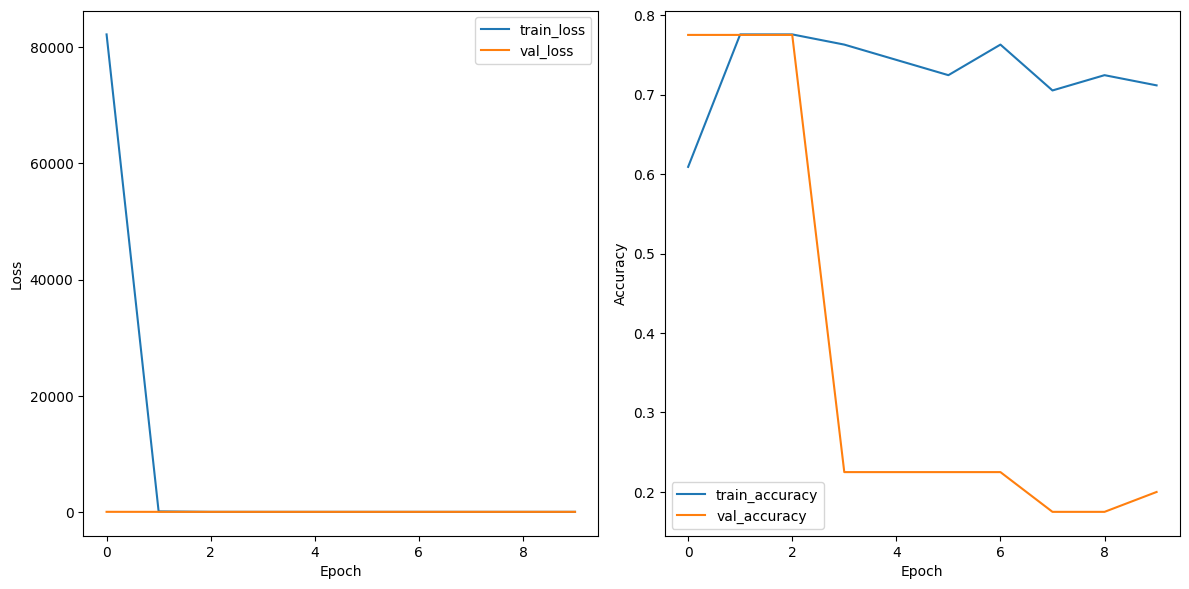

In [59]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# save the model
if not os.path.exists('models'):
    os.makedirs('models')
model.save('models/prosody_cnn_10.h5')

## BiLSTM

In [ ]:
X = [np.nan_to_num(arr.astype(float), nan=0.0) for arr in df['Prosodic_Features']]
y = df['PHQ_Binary'].astype(int).values

print(len(X), X[0].shape, y.shape)

In [61]:
max_len = max(seq.shape[0] for seq in X)  # longest sequence length
n_features = X[0].shape[1]
print(f"Max length: {max_len}, Number of features: {n_features}")

lengths = [seq.shape[0] for seq in X]
max_len = int(np.mean(lengths))  # round down to int
print(f"Average length: {max_len}")

# minium length for padding
min_len = min(lengths)
print(f"Minimum length: {min_len}")

X_pad = pad_sequences(X, maxlen=min_len, dtype='float32', padding='post')
print("Data shape:", X_pad.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Max length: 39316, Number of features: 16
Average length: 19275
Minimum length: 8288
Data shape: (196, 8288, 16)
Train set shape: (156, 8288, 16) (156,)
Test set shape: (40, 8288, 16) (40,)


In [62]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential([
    Masking(mask_value=0.0, input_shape=(n_timesteps, n_features)),  # ignore padded zeros
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 8288, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8288, 128)      │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8288, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,801 (331.25 KB)

 Trainable params: 84,801 (331.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
epochs = 10
batch_size = 16

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10


2025-08-12 23:20:02.469206: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5365 - loss: 0.6785 - val_accuracy: 0.7750 - val_loss: 0.5447
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.8080 - loss: 0.5140 - val_accuracy: 0.7750 - val_loss: 0.5346
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.7677 - loss: 0.5361 - val_accuracy: 0.7750 - val_loss: 0.5369
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.8198 - loss: 0.4747 - val_accuracy: 0.7750 - val_loss: 0.5333
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.7951 - loss: 0.5051 - val_accuracy: 0.7750 - val_loss: 0.5317
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.7576 - loss: 0.5586 - val_accuracy: 0.7750 - val_loss: 0.5354
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.8304 - loss: 0.4611 - val_accuracy: 0.7750 - val_loss: 0.5395
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.7513 - loss: 0.5562 - val_accuracy: 0.7750 - val_loss: 0.5365
Epo

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.7771 - loss: 0.5335
Test Loss: 0.5370, Test Accuracy: 0.7750


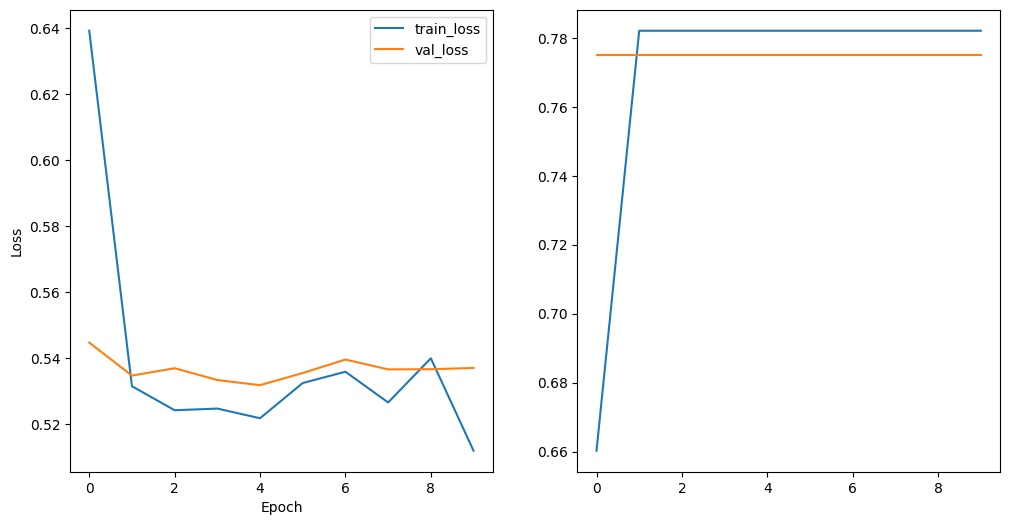

In [64]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy') 

In [65]:
# save the model
model.save('models/prosody_lstm_10.h5')